In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_simulation import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results

In [12]:
dirs = ["coif5_saliency_warmstart_seed=1"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/simulation/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave='coif5', mode='zero', J=4, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [13]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)

index = {}
for i, _ in enumerate(lamL1wave_grid):
    for j, _ in enumerate(lamL1attr_grid):
        loc = (lamL1wave == lamL1wave_grid[i]) & (lamL1attr == lamL1attr_grid[j])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            index[(i,j)] = loc

# Plotting

Hyperparameter: lamL1wave=0.001880 lamL1attr=0.483290
Error: Recon=0.005090
Sparsity: Wave=11.008883
Interp: Saliency=2.362984 InputXGrade=1.798511
Wavelet loss: lSum=0.000001 hsum=0.000001 L2norm=0.000003 CMF=0.001106 Conv=0.000025


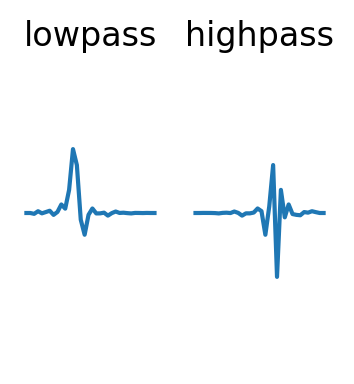

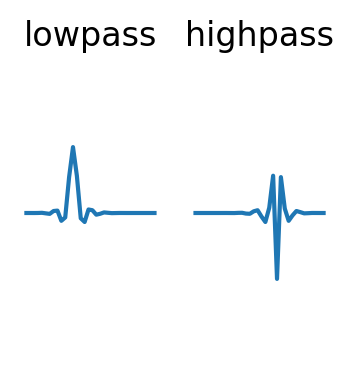

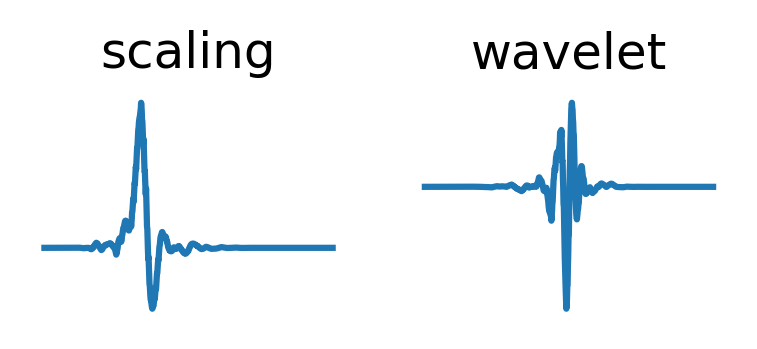

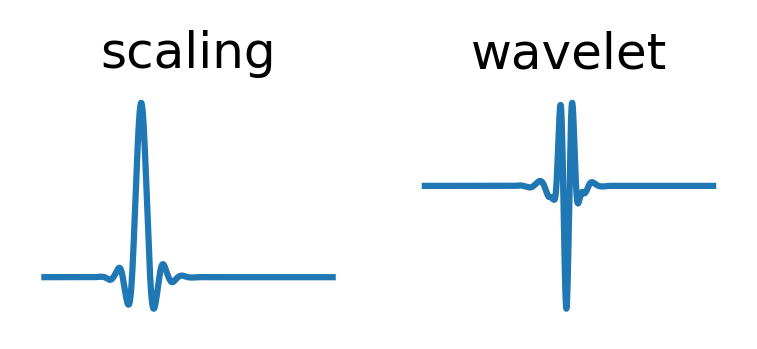

In [16]:
idx1 = 3 # index for lamL1wave
idx2 = 15 # index for lamL1attr
wt = mos[index[(idx1, idx2)]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][index[(idx1, idx2)]], res['lamL1attr'][index[(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][index[(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][index[(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][index[(idx1, idx2)]], res['L1inputxgrad_loss'][index[(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][index[(idx1, idx2)]],
                                                                                          res['hsum_loss'][index[(idx1, idx2)]],
                                                                                          res['L2norm_loss'][index[(idx1, idx2)]],
                                                                                          res['CMF_loss'][index[(idx1, idx2)]],
                                                                                          res['conv_loss'][index[(idx1, idx2)]]))

# original wavelet
wt0 = DWT1d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)
filt0 = get_1dfilts(wt0)
phi0, psi0, x0 = get_wavefun(wt0)

plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_1dfilts(filt0, is_title=True, figsize=(2,2))

plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))
plot_wavefun((phi0, psi0, x0), is_title=True, figsize=(3,1))

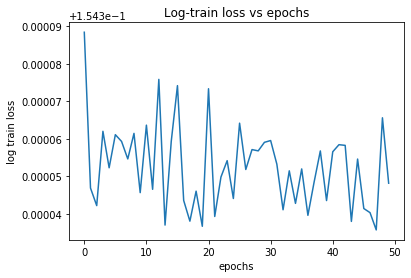

In [17]:
plt.plot(np.log(res['train_losses'][index[(idx1, idx2)]]))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()